# GNN on MIMIC-III EHR

- Goal here is to take the embedding of the GNN model and create Graph > spectral clustering > survival analysis 
- and compare with SNF results.

In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx 
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split


In [2]:
folder_path = 'Data/MIMIC resources'

df_Admissions = pd.read_csv(f'{folder_path}/ADMISSIONS.csv')

df_Patients = pd.read_csv(f'{folder_path}/PATIENTS.csv')

# medication!
df_Prescription = pd.read_csv(f'{folder_path}/PRESCRIPTIONS.csv')

# Diagnosis!
df_DiagnosisICD = pd.read_csv(f'{folder_path}/DIAGNOSES_ICD.csv')

# Procedures!
df_ProceduresICD = pd.read_csv(f'{folder_path}/PROCEDURES_ICD.csv')
# ICUStays
df_Icustays = pd.read_csv(f'{folder_path}/ICUSTAYS.csv')


df_ProceduresICD.dropna(subset=['ICD9_CODE'], inplace=True)
df_Prescription.dropna(subset=['drug'], inplace=True)
df_DiagnosisICD.dropna(subset=['ICD9_CODE'], inplace=True)

In [3]:
# convert all procedure codes into two digits only
# convert all diagnosis codes into three digits only

def extract3(code):
    return str(code)[:3]
def extract2(code):
    return str(code)[:2]

df_DiagnosisICD['ICD9_CODE'] = df_DiagnosisICD['ICD9_CODE'].apply(extract3)
df_ProceduresICD['ICD9_CODE'] = df_ProceduresICD['ICD9_CODE'].apply(extract2)

df_ProceduresICD


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,944,62641,154460,3,34
1,945,2592,130856,1,96
2,946,2592,130856,2,38
3,947,55357,119355,1,96
4,948,55357,119355,2,33
...,...,...,...,...,...
240090,228330,67415,150871,5,37
240091,228331,67415,150871,6,38
240092,228332,67415,150871,7,88
240093,228333,67415,150871,8,38


In [4]:
Procedures = sorted(df_ProceduresICD['ICD9_CODE'].unique())
Medication = sorted(df_Prescription['drug'].unique())
Diagnosis  = df_DiagnosisICD['ICD9_CODE'].unique()
Patients = df_Patients['SUBJECT_ID'].unique()
Admissions = df_Admissions['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')

print(f'Number of Admissions = {len(Admissions)}')

print(f'Number of Diagnosis = {len(Diagnosis)}')

print(f'Number of procedures = {len(Procedures)}')

print(f'Number of Medication = {len(Medication)}')

Number of Patients = 46520
Number of Admissions = 58976
Number of Diagnosis = 942
Number of procedures = 89
Number of Medication = 592


# LUNG Patients only
**ICD9=162**

## Extracting visits (admissions) of each patient sorted by its date.

In [5]:
def getDict(A, DF, label1, label2):
    # Extracting the list of NODES for each A item. 
    # Filter the dataframe to extract Nodes associated with the specified label1
    # Extract the list of Nodes associated with the patient
    D = {}
    for v in A:
        df = DF[DF[label1] == v]
        id_list = df[label2].tolist()
        if len(id_list)>0:
            D[v] = id_list
    
    return D

# def getNodes_and_Edges(D):
#     DNodes, DEdges = [], []
#     for i, v in D.items():
#         for j in v:
#             if isinstance(j, (int, float, str)) and not np.isnan(j):
#                 DEdges.append([i,j])
#                 if j not in DNodes:
#                     DNodes.append(j)
#     return DNodes, DEdges

def getNodes_and_Edges(D):
    DEdges = []
    DNodes = []
    for i, v in D.items():
        for j in v:
            if isinstance(j, (int, float)) and not np.isnan(j):
                DEdges.append([i, j])
                if j not in DNodes:
                    DNodes.append(j)
            elif isinstance(j, str):
                # Check if it's a valid numeric string before treating it as a node
                try:
                    numeric_value = float(j)
                    DEdges.append([i, numeric_value])
                    if numeric_value not in DNodes:
                        DNodes.append(numeric_value)
                except ValueError:
                    # If it's not a valid numeric string, treat it as a regular string node
                    DEdges.append([i, j])
                    if j not in DNodes:
                        DNodes.append(j)
    return DNodes, remove_red(DEdges)

def remove_red(DEdges):
    f = []
    for u,v in DEdges:
        if [u,v] not in f:
            f.append([u,v])
    return f


In [6]:
# # restricting to LUNG disease
# ICD_Diagnosis_Lung = [i for i in Diagnosis if str(i).startswith('162')]

df_sub = df_DiagnosisICD[df_DiagnosisICD['ICD9_CODE'].str.startswith('162')]

df_sub = df_sub[['SUBJECT_ID',	'HADM_ID']].dropna(subset=['HADM_ID'])
df_sub

,SUBJECT_ID,HADM_ID
584,103,130744
592,103,133550
1037,56,181711
1936,291,126219
2541,150,108732
...,...,...
649252,97301,195551
650147,97603,166108
650674,96004,141589
650784,96023,116385


In [7]:
Patients = df_sub['SUBJECT_ID'].unique()
Admissions = df_sub['HADM_ID'].unique()

print(f'Number of Patients = {len(Patients)}')
print(f'Number of Admission = {len(Admissions)}')

Number of Patients = 998
Number of Admission = 1171


## Extracting time to death

In [8]:
newDF = df_Admissions[df_Admissions['HADM_ID'].isin(Admissions)]
newDF = newDF[['SUBJECT_ID','HADM_ID','ADMITTIME','DEATHTIME', 'HOSPITAL_EXPIRE_FLAG']]
newDF

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG
57,56,181711,2104-01-02 02:01:00,2104-01-08 10:30:00,1
108,103,130744,2144-08-12 17:37:00,NaN,0
109,103,133550,2144-08-30 23:09:00,2144-09-01 14:28:00,1
161,150,108732,2161-07-09 17:54:00,NaN,0
318,463,197296,2198-10-05 16:43:00,NaN,0
...,...,...,...,...,...
58790,91872,195348,2174-11-04 06:42:00,NaN,0
58818,93831,107720,2116-11-17 18:05:00,NaN,0
58826,93840,103601,2101-07-11 11:16:00,NaN,0
58841,96254,140723,2129-08-14 14:02:00,2129-08-14 20:03:00,1


In [9]:
df = newDF
df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME'])
df['DEATHTIME'] = pd.to_datetime(df['DEATHTIME'])

# Filter rows with the least ADMITTIME per SUBJECT_ID
admit_df = df.sort_values('ADMITTIME').groupby('SUBJECT_ID').head(1)

admit_df = admit_df[['SUBJECT_ID','ADMITTIME']]

death_df = df[df['DEATHTIME'].notnull()].sort_values('DEATHTIME').groupby('SUBJECT_ID').head(1)

death_df = death_df[['SUBJECT_ID','DEATHTIME']]

final_df = admit_df.merge(death_df, on='SUBJECT_ID', how='outer').sort_values(by='SUBJECT_ID')

Patients = final_df['SUBJECT_ID'].unique()

final_df.to_csv('Data/survival.csv')
final_df


,SUBJECT_ID,ADMITTIME,DEATHTIME
28,56,2104-01-02 02:01:00,2104-01-08 10:30:00
417,103,2144-08-12 17:37:00,2144-09-01 14:28:00
597,150,2161-07-09 17:54:00,NaT
393,222,2142-06-11 07:15:00,NaT
11,281,2101-10-18 04:42:00,2101-10-25 19:10:00
...,...,...,...
431,99339,2145-10-14 02:26:00,NaT
164,99384,2117-11-29 07:15:00,NaT
809,99469,2183-04-16 23:20:00,2183-05-13 16:20:00
640,99556,2165-12-25 12:44:00,2167-07-31 21:53:00


In [10]:
# Filter rows with non-null DEATHTIME and extract SUBJECT_ID values
dead = final_df[final_df['DEATHTIME'].notnull()]['SUBJECT_ID'].tolist()
dead_patients = [f'C_{i}' for i in dead]

## Extracting the edges

In [11]:
VisitDict      = getDict(Patients, df_sub, 'SUBJECT_ID', 'HADM_ID')

VisitNodes, PatientVisit = getNodes_and_Edges(VisitDict)
print(f'Total number of patient-visit = {len(PatientVisit)}')


# -----------------------------------------------------------------------------
DiagnosisDict  = getDict(VisitNodes, df_DiagnosisICD, 'HADM_ID', 'ICD9_CODE')
DiagnosisNodes, VisitDiagnosis = getNodes_and_Edges(DiagnosisDict)
print(f'Total number of Visit-Diagnosis = {len(VisitDiagnosis)}')


# -----------------------------------------------------------------------------
ProcedureDict  = getDict(VisitNodes, df_ProceduresICD, 'HADM_ID', 'ICD9_CODE')
ProcedureNodes, VisitProcedure = getNodes_and_Edges(ProcedureDict)
print(f'Total number of Visit-Procedure = {len(VisitProcedure)}')


# -----------------------------------------------------------------------------
MedicationDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'drug')
MedicationNodes, VisitMedication = getNodes_and_Edges(MedicationDict)
print(f'Total number of Visit-Medication = {len(VisitMedication)}')


# -----------------------------------------------------------------------------
ICUSTAYDict = getDict(VisitNodes, df_Prescription, 'hadm_id', 'icustay_id')
ICUSTAYNodes, VisitICUSTAY = getNodes_and_Edges(ICUSTAYDict)
print(f'Total number of Visit-ICUSTAY = {len(VisitICUSTAY)}')

# # -----------------------------------------------------------------------------
# ICUSTAY_MedicationDict = getDict(ICUSTAYNodes, df_Prescription, 'icustay_id', 'drug')
# _, ICUSTAY_Medication = getNodes_and_Edges(ICUSTAY_MedicationDict)
# print(f'Total number of ICUSTAY-Medication = {len(ICUSTAY_Medication)}')

Total number of patient-visit = 1171
Total number of Visit-Diagnosis = 13757
Total number of Visit-Procedure = 3593
Total number of Visit-Medication = 334
Total number of Visit-ICUSTAY = 8


### Mapping function for Nodes and edges

In [12]:
# c, C : Patients
# v, V : visits
# d, D : Diagnosis
# p, P : Procedure
# m, M : Medication
# i, I : ICUSTAY

CV_edges = [[f'C_{u}', f'V_{v}'] for u,v in PatientVisit]
VD_edges = [[f'V_{u}', f'D_{v}'] for u,v in VisitDiagnosis]
VP_edges = [[f'V_{u}', f'P_{v}'] for u,v in VisitProcedure]
VM_edges = [[f'V_{u}', f'M_{v}'] for u,v in VisitMedication]
VI_edges = [[f'V_{u}', f'I_{v}'] for u,v in VisitICUSTAY]
# IM_edges = [[f'I_{u}', f'M_{v}'] for u,v in ICUSTAY_Medication]

In [13]:
edge_index = CV_edges + VD_edges + VP_edges + VM_edges #+ VI_edges

tempG = nx.Graph()
tempG.add_edges_from(edge_index)

Nodes = list(tempG.nodes())
N = len(Nodes)

C_index = [i for i, v in enumerate(Nodes) if v[0]=='C']
V_index = [i for i, v in enumerate(Nodes) if v[0]=='V']
M_index = [i for i, v in enumerate(Nodes) if v[0]=='M']
D_index = [i for i, v in enumerate(Nodes) if v[0]=='D']
P_index = [i for i, v in enumerate(Nodes) if v[0]=='P']

In [14]:
# A1 : V-D-V

A = np.zeros((N, N))
for u,v in tempG.edges:
    i, j = Nodes.index(u), Nodes.index(v)
    A[i,j] = 1
    A[j,i] = 1
    
VDV_A = np.zeros((N, N))

newG = nx.Graph()
newG.add_edges_from(VD_edges)

for i in range(len(V_index)-1):
    for j in range(i, len(V_index)):
        ni, nj = V_index[i], V_index[j]
        u, v = Nodes[ni], Nodes[nj]

        Nu = set(newG.neighbors(u))
        Nv = set(newG.neighbors(v))

        Intersection = Nu.intersection(Nv)
        VDV_A[ni, nj] = 2 * (len(Intersection)) / (len(Nu) + len(Nv))
        VDV_A[nj, ni] = 2 * (len(Intersection)) / (len(Nu) + len(Nv))

In [15]:
def threeNodes(VA_edges, VB_edges, A_index, B_index, Nodes):
    A = np.zeros((N, N))

    newG = nx.Graph()
    newG.add_edges_from(VA_edges)
    newG.add_edges_from(VB_edges)

    for u in A_index:
        for v in B_index:
            U, V = Nodes[u], Nodes[v]
            Nu = set(newG.neighbors(U))
            Nv = set(newG.neighbors(V))

            Intersection = Nu.intersection(Nv)
            w = 2 * (len(Intersection)) / (len(Nu) + len(Nv))
            A[u, v] = w
            A[v, u] = w
            # if w!=0:
            #     print(U, V, Intersection, w)
    return A

DVM_A = threeNodes(VD_edges, VM_edges, D_index, M_index, Nodes)
CVM_A = threeNodes(CV_edges, VM_edges, C_index, M_index, Nodes)
CVP_A = threeNodes(CV_edges, VP_edges, C_index, P_index, Nodes)
CVD_A = threeNodes(CV_edges, VD_edges, C_index, D_index, Nodes)
MVP_A = threeNodes(VM_edges, VP_edges, M_index, P_index, Nodes)
DVP_A = threeNodes(VD_edges, VP_edges, D_index, P_index, Nodes)

In [16]:
import numpy as np
from scipy.optimize import minimize
As = [A, VDV_A, DVM_A, CVM_A, CVP_A, CVD_A, MVP_A, DVP_A]

K = len(As)

def objective(weights, matrices):
    weighted_sum = np.zeros_like(matrices[0])
    for w, A_i in zip(weights, matrices):
        weighted_sum += w * A_i
    return np.linalg.norm(weighted_sum, 'fro')

def constraint(weights):
    return np.sum(weights) - 1

initial_weights = np.ones(K) / K

result = minimize(objective, initial_weights, args=(As,), constraints={'type': 'eq', 'fun': constraint})

W = result.x

print("Optimized weights:", W)

A_meta = sum(W[k] * As[k] for k in range(len(W)))
A_meta.shape


Optimized weights: [1.00013826e-04 4.61689471e-05 1.52381560e-01 1.40200926e-02
 8.76033664e-02 9.17914854e-03 7.00351252e-01 3.63183976e-02]


(2821, 2821)

In [17]:
# import pickle

# with open('Data/OneScalar.pkl', 'wb') as file:
#     pickle.dump(A_meta, file)

# nx.write_gml(tempG, 'Data/OneScalarGraph.gml')   


In [18]:
Y = {}
for i in Nodes:
    if i[0]=='C':
        if i in dead_patients:
            Y[i] = 1
        else:
            Y[i] = 0
    else:
        Y[i] = 2

In [19]:
X = np.random.randn(len(Nodes), 128)
# X = np.eye(Total_number_of_nodes)

num_classes = 2
num_features = X.shape[1]

G = nx.Graph()

G.add_nodes_from([
    (v, {'y': Y[v], 'x': X[i]}) for i, v in enumerate(list(tempG.nodes()))
    ])

for i in range(len(Nodes)):
    for j in range(i + 1, len(Nodes)):
        weight = A_meta[i, j]
        if weight > 0:
            G.add_edge(Nodes[i], Nodes[j], weight=weight)

G.add_edges_from(edge_index)

data = from_networkx(G)
data


c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


Data(x=[2821, 128], edge_index=[2, 1462786], y=[2821], weight=[1462786])

## Creating new masks out of patient nodes only

In [20]:
data.y
newY = []
for i,v in enumerate(list(data.y)):
    if v in [0,1]:
        newY.append([i,v])

y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)
print('Train = ', sum([1 if v else 0 for v in train_mask])/998)
print('Val = ', sum([1 if v else 0 for v in val_mask])/998)
print('Test = ', sum([1 if v else 0 for v in test_mask])/998)

(2821,)
(2821,)
(2821,)
Train =  0.6993987975951904
Val =  0.10020040080160321
Test =  0.20040080160320642


In [21]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

Epoch: 010, Train Loss: 0.596, Val Acc: 0.710
Epoch: 020, Train Loss: 0.565, Val Acc: 0.710


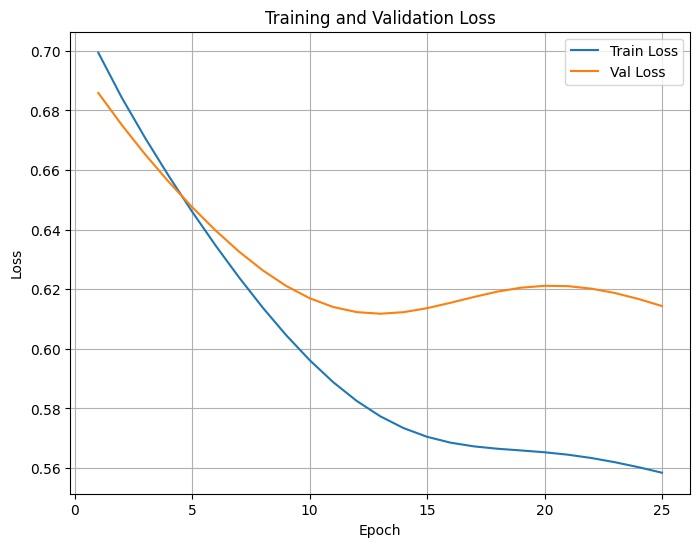

[[147   0]
 [ 53   0]]
F1 score =  0.4236311239193084
Precision score =  0.3675
AUC Precision score =  0.265


c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Acc: 0.735



In [22]:
import GNNModel as GNNM
import torch

data.x = data.x.float()
data.y = data.y.long()

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.GCN(data.num_node_features, num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=25)

GNNM.plt_performance(df)
# ----------------------------------------------------------------------------
pred = gcn(data).argmax(dim=1)

pred = pred[data.test_mask] .detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

GNNM.create_confusion_matrix(pred, correct)


test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
print(f'Test Acc: {test_acc:.3f}\n')